In [1]:
from numpy import *
from matplotlib.pyplot import *
from skimage import io

from sys import path
from os.path import abspath
path.append(abspath('../..'))
from crnpy.colors import cyan,yellow

from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import Pipeline

from glob import glob
from os import system
    
# basis function
def sigmoid(x) :
    return 1.0/(1.0+exp(-x))

# feature vector
def features(x,degree=3) :
    x = squeeze(x)
    fx = [ sigmoid(sigma*(x-mu)) for mu in linspace(0.25,.75,num=degree) for sigma in [-20,20] ]
    return stack(fx,axis=-1)


def fit(data,threshold = 25000,t_final=24,x_width=1.0) :
    
    # create coordinate meshes
    n_frames,height,width,n_channels = data.shape
    x,t = linspace(0,x_width,num=width),linspace(0,t_final,num=n_frames)

    xx,tt = meshgrid(x,t)
    X,Y = meshgrid(x,linspace(0,1,num=height))
    cfp,yfp,rfp = 0,1,2
    
    # intensity normalisation
    data /= nanmax(data,axis=(0,1,2))

    # setting values outside grid squares to nan
    mask = data[-1,...,rfp] < 0.5
    mask = stack([[ mask for _ in range(n_frames) ] for _ in range(n_channels) ],axis=-1)
    data[mask] = NaN
    
    # create regressors
    yfp_predictor = Pipeline([("feature-map", FunctionTransformer(features)), ("regressor", BayesianRidge() )])
    cfp_predictor = Pipeline([("feature-map", FunctionTransformer(features)), ("regressor", BayesianRidge() )])

    # fit both channels for each timepoint
    yfp_predictions,cfp_predictions = [],[]
    for t in range(n_frames):

        input = data[t,...,yfp]
        yfp_predictor.fit(X[~isnan(input)].reshape(-1,1),input[~isnan(input)].reshape(-1,1))
        yfp_predictions += [yfp_predictor.predict(x.reshape(-1,1))]

        input = data[t,...,cfp]
        cfp_predictor.fit(X[~isnan(input)].reshape(-1,1),input[~isnan(input)].reshape(-1,1))
        cfp_predictions += [cfp_predictor.predict(x.reshape(-1,1))]

    predictions = stack([yfp_predictions,cfp_predictions],axis=-1)
    return xx,tt,predictions,yfp_predictor,cfp_predictor

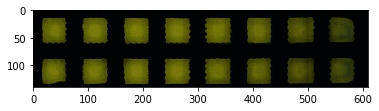

In [23]:
imshow(io.imread('./0-3.tif')[50])

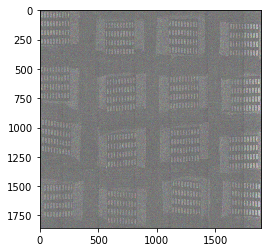

In [23]:
imshow(io.imread('./20191127 exrep 10uM IPTG_flipped.tif'))

In [2]:
image = io.imread('./20191127 exrep 10uM IPTG_flipped.tif')

In [4]:
last = image[-1]

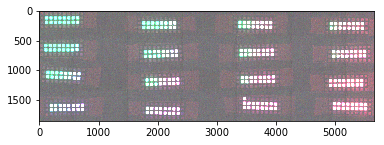

In [5]:
imshow(last)

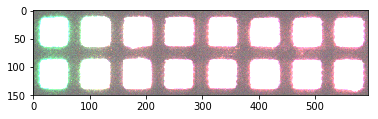

In [213]:
imshow(last[175:325,4905:5500])

In [214]:
io.imsave('./3-3.tif',image[:,175:325,4905:5500,:])

In [2]:
cfp,yfp,rfp = 0,1,2
data = io.imread('C12500C6160.tif').astype(float)
xx,tt,predictions,yfp_steady_state,cfp_steady_state = fit(data)

/home/gszep/.local/lib/python2.7/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/gszep/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.1296023564064801

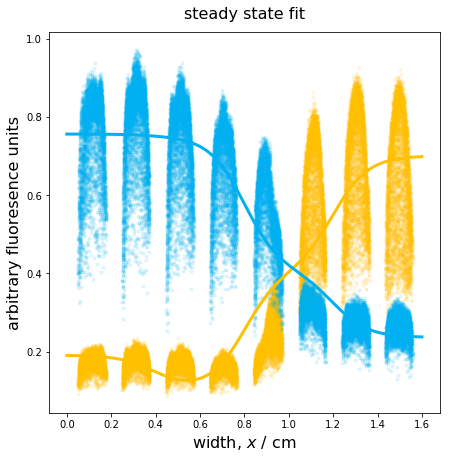

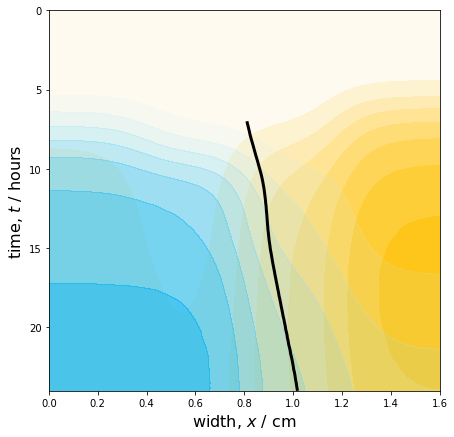

In [3]:
figure(figsize=(7,7))
title('steady state fit', fontsize=16, y=1.02)
plot(1.6*xx[0],data[-1,...,yfp].T,'.',color='#ffc000',alpha=0.1)
plot(1.6*xx[0],data[-1,...,cfp].T,'.',color='#00b0f0',alpha=0.1)

plot(1.6*xx[0],yfp_steady_state.predict(xx[0].reshape(-1,1)),color='#ffc000',linewidth=3)
plot(1.6*xx[0],cfp_steady_state.predict(xx[0].reshape(-1,1)),color='#00b0f0',linewidth=3)

xlabel('width, $x$ / cm',fontsize=16)
ylabel('arbitrary fluoresence units',fontsize=16);

figure(figsize=(7,7))

contourf(1.6*xx,tt,predictions[...,0],cmap='yellow',alpha=1)
contourf(1.6*xx,tt,predictions[...,1],cmap='cyan')

difference = predictions[...,0].T-predictions[...,1].T
difference[(tt<7).T] = NaN
contour(1.6*xx.T,tt.T,difference,levels=[0],colors=['black'],linewidths=[3])

xlabel('width, $x$ / cm',fontsize=16)
ylabel('time, $t$ / hours',fontsize=16);
gca().invert_yaxis()

boundary_index = argmin(abs(difference),axis=0)
boundary_index = boundary_index[boundary_index>0]
boundary = xx[0][boundary_index]
max(boundary) - min(boundary)

In [4]:
figure(figsize=(11,7))

headers,labels = [],[]
c = ['darkgoldenrod','goldenrod','gold','cornsilk','lightcyan','darkturquoise','darkcyan']

for i,file_path in enumerate(sort(glob('./*.tif'))[:-1]) :

    data = io.imread(file_path).astype(float)
    name = file_path.replace('.tif','').replace('./','')
    xx,tt,env,f,g = fit(data)
    
    difference = env[...,0].T-env[...,1].T
    difference[(tt<8).T] = NaN
    
    contour_object = contour(1.6*xx.T,tt.T,difference,levels=[0],linewidths=[3],colors=[c[i]])
    header,_ = contour_object.legend_elements()
    
    headers += [header[0]]
    labels += [name]
    
xlabel('width, $x$ / cm',fontsize=16)
ylabel('time, $t$ / hours',fontsize=16)

gca().invert_yaxis()
legend(headers,labels,fontsize=16)
xlim(0,1.6)

KeyboardInterrupt: 

<Figure size 792x504 with 0 Axes>

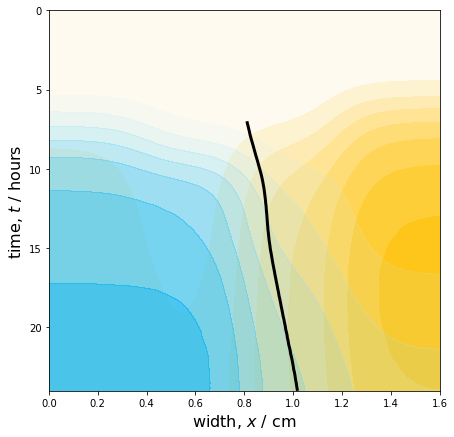

In [10]:
figure(figsize=(7,7))

contourf(1.6*xx,tt,env[...,0],cmap='yellow',alpha=1)
contourf(1.6*xx,tt,env[...,1],cmap='cyan')

difference = env[...,0].T-env[...,1].T
difference[(tt<7).T] = NaN
contour(1.6*xx.T,tt.T,difference,levels=[0],colors=['black'],linewidths=[3])

xlabel('width, $x$ / cm',fontsize=16)
ylabel('time, $t$ / hours',fontsize=16);
gca().invert_yaxis()